In [43]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
%matplotlib inline 


In [44]:
model = tf.keras.models.load_model("model/garbage_classification_resnet.h5")

src = cv2.imread("test/mask.jpg", cv2.IMREAD_COLOR)
dst = cv2.resize(src, dsize=(299, 299), interpolation=cv2.INTER_AREA)
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

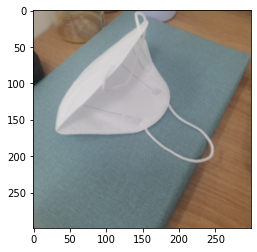

In [45]:
plt.imshow(dst, interpolation='bicubic')
plt.show()

In [46]:
x_test = dst.astype('float32').reshape(1,299,299,3) / 255.0

y_test = model.predict(x_test)


In [47]:
print(y_test)

[[1.9381505e-05 2.3420781e-03 6.6359735e-01 8.3559034e-03 1.3271376e-03
  4.6889560e-04 2.8169689e-01 1.3143837e-04 4.2061046e-02]]


In [48]:
from PIL import Image


def load_image(img_path, scaling):
    img = Image.open(img_path)
    img = img.resize([299, 299])
    img.load()
    data = np.float32(img)

    # 스케일링 유무에 따라 결과가 달라진다. 하는 것이 좋은 결과를 만든다.
    # 학습할 때 스케일링을 적용했기 때문에 여기서도 적용하는 것이 맞다.
    if scaling:
        data /= 255.0
    return data

In [49]:
def test_tflite_model(tflite_path, images):
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()

    # 입력 텐서 정보 : 인덱스를 알아야 데이터를 전달할 수 있다.
    input_details = interpreter.get_input_details()
    # [{'name': 'conv2d_60_input', 'index': 3, 'shape': array([  1, 150, 150,   3], dtype=int32),
    #   'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}]

    # 출력 텐서 정보 : 인덱스를 알아야 결과를 받아올 수 있다.
    output_details = interpreter.get_output_details()
    # [{'name': 'dense_41/Sigmoid', 'index': 18, 'shape': array([1, 1], dtype=int32),
    #   'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}]

    result = []
    for img_path in images:
        input_data = load_image(img_path, scaling=True)
        input_data = input_data[np.newaxis]

        # 입력 데이터 전달
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()

        # 출력 데이터 읽기
        output_data = interpreter.get_tensor(output_details[0]['index'])
        result.append(output_data)

    # 1차원 변환 출력
    print(np.reshape(result, -1))


# 텐서플로 라이트 모델 경로와 시험할 사진 경로 전달
test_tflite_model('model/garbage_classification.tflite', ['test/vinyl.jpg'])


[1.7091537e-05 1.4458522e-04 1.5879703e-03 1.5838511e-02 7.7584811e-04
 4.1806617e-01 3.6474916e-01 2.7777324e-03 1.9604293e-01]
